In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np

def conv(z, h, omega_lambda, omega_matter):

    H0=100*h
#conversion Mpc --> km
    conv1=1./(1e6*206265*1.496e8)
#conversion de s --> Gyr
    conv2=3600*24*365.25*1e9
    H0=H0*conv1*conv2

    c1=np.sqrt(omega_lambda*(1.+z)**(-3.))+np.sqrt((omega_lambda*(1.+z)**(-3.))+omega_matter)
    ln=np.log(c1/np.sqrt(omega_matter))
    c2=2./(3.*np.sqrt(omega_lambda))
        
    time = (1./H0)*c2*ln

    return time

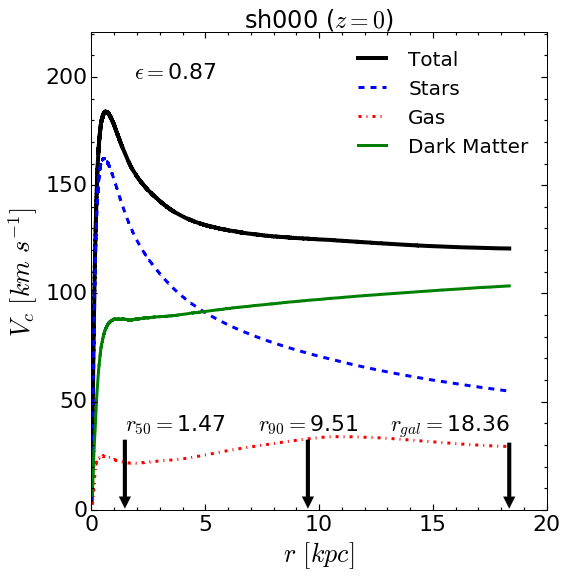

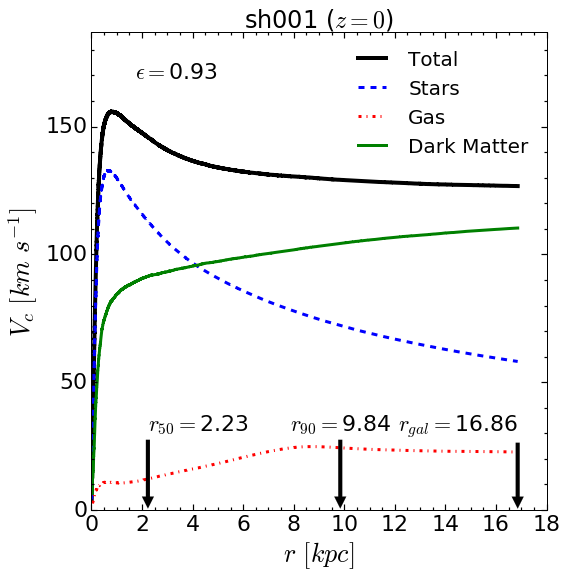

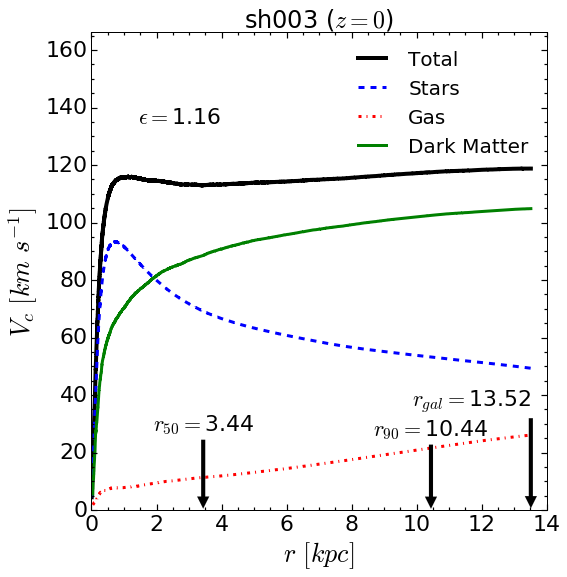

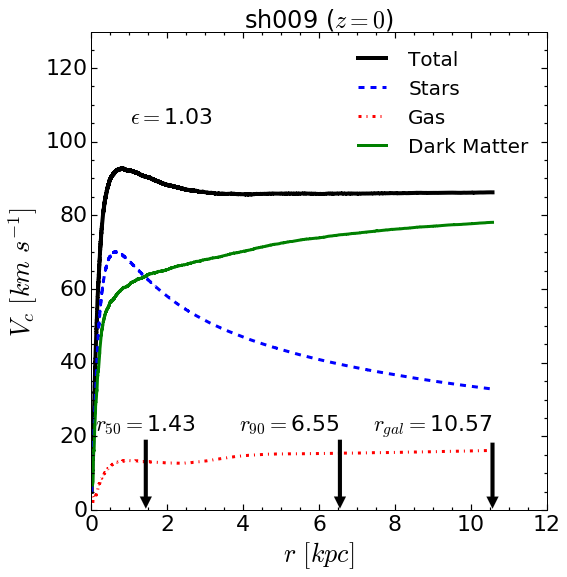

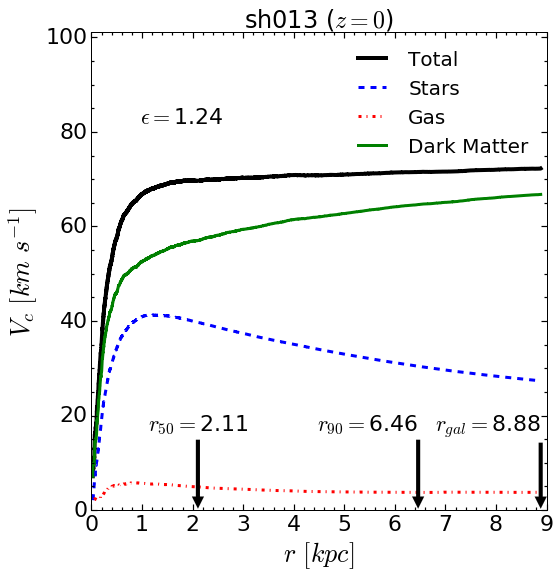

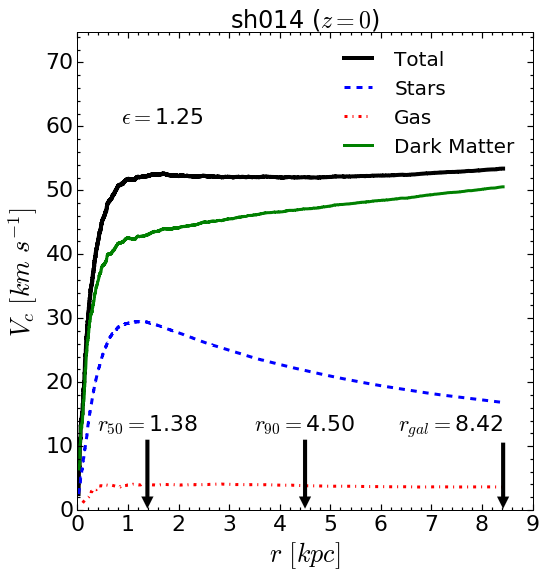

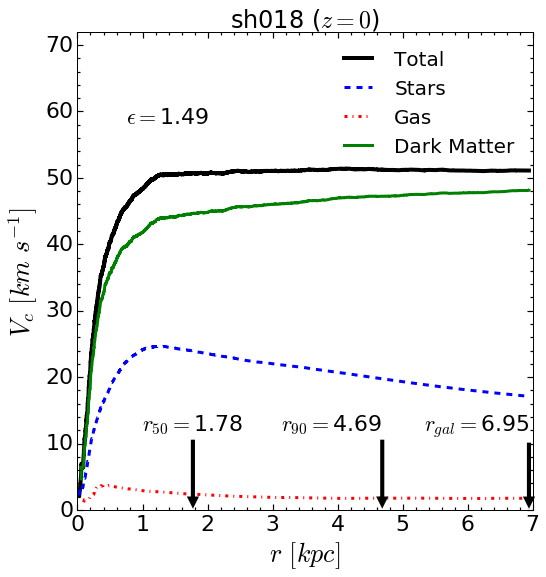

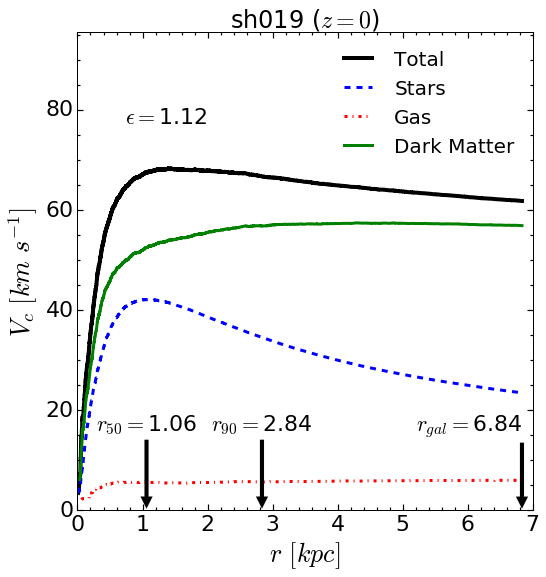

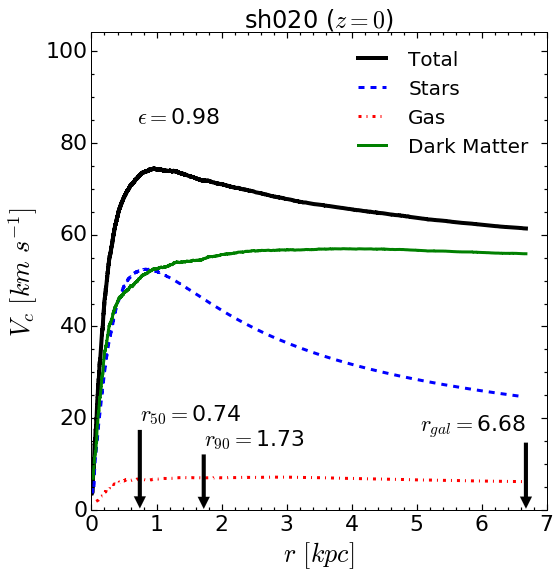

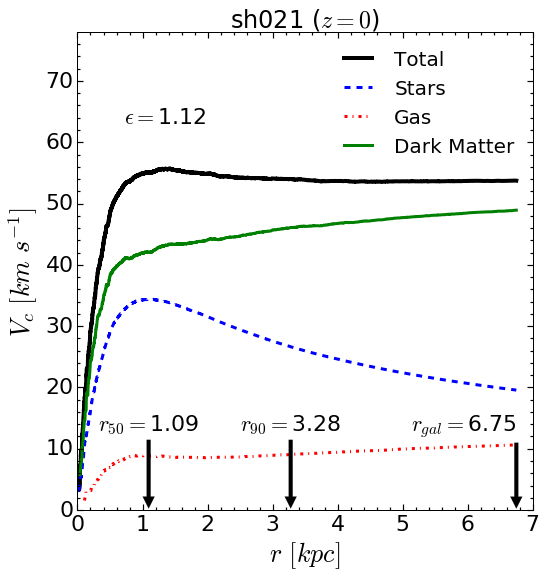

In [10]:
#Graficamos la veloc circular
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np

vector = ('00','01','03','09','13','14','18','19','20','21')

h=0.732
G = 4.299e-6

snapshot=range(497,496,-1)

for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    for i in range(0,10):
        
        cm=np.loadtxt('/home/ornela/python/inest-s'+'%s' %vector[i]+'.dat')
        epsilon =cm[:,1]
        
        pstr = snap['subhalo_0'+ str('%s'%vector[i]) +'/Str/Coordinates'].value
        cm   = snap['subhalo_0'+ str('%s'%vector[i]) +'/Center'].value
        vel  = snap['subhalo_0'+ str('%s'%vector[i]) +'/Str/Velocities'].value
        masa_str = snap['subhalo_0'+ str('%s'%vector[i]) +'/Str/Masses'].value
        r200 = snap['subhalo_0'+ str('%s'%vector[i]) +'/R200'].value
        
        pgas = snap['subhalo_0'+ str('%s'%vector[i]) +'/Gas/Coordinates'].value
        masa_gas = snap['subhalo_0'+ str('%s'%vector[i]) +'/Gas/Masses'].value
        
        pdrk = snap['subhalo_0'+ str('%s'%vector[i]) +'/Drk/Coordinates'].value
        masa_drk = snap['subhalo_0'+ str('%s'%vector[i]) +'/Drk/Masses'].value
        
#----------coordenadas respecto al centro de la galaxia-----------------
        xstr = (pstr[:,0]-cm[0])/h
        ystr = (pstr[:,1]-cm[1])/h
        zstr = (pstr[:,2]-cm[2])/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])/h
        ygas = (pgas[:,1]-cm[1])/h
        zgas = (pgas[:,2]-cm[2])/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])/h
        ydrk = (pdrk[:,1]-cm[1])/h
        zdrk = (pdrk[:,2]-cm[2])/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
        
#----------------------masas----------------------------
        masa_str = masa_str/h
        masa_gas = masa_gas/h
        masa_drk = masa_drk/h
        
        rgal=0.15*r200
        
        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
        
        limit_gas = np.where(rgas<rgal)
        rgas_sort = np.sort(rgas[limit_gas])
        rgas_indice = np.argsort(rgas[limit_gas])
        
        limit_drk = np.where(rdrk<rgal)
        rdrk_sort = np.sort(rdrk[limit_drk])
        rdrk_indice = np.argsort(rdrk[limit_drk])
        
        Mc_str = cumsum((masa_str[limit])[r_indice])
        
        Mc_gas = cumsum((masa_gas[limit_gas])[rgas_indice])
        
        Mc_drk = cumsum((masa_drk[limit_drk])[rdrk_indice])
        
#------------------ calculamos r90, r50------------------------------------------
        M_gal = Mc_str[-1]
    
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
#--------------------------------------------------------------       
        rtot= concatenate([r,rgas,rdrk])
        mtot= concatenate([masa_str, masa_gas, masa_drk])
        
        limit_tot = np.where(rtot<rgal)
        rtot_sort = np.sort(rtot[limit_tot])
        rtot_indice = np.argsort(rtot[limit_tot])
        
        Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])
#--------------------------------------------------------------
        
        Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)
        Vstr = np.sqrt((G*Mc_str*1e10)/r_sort)
        Vgas = np.sqrt((G*Mc_gas*1e10)/rgas_sort)
        Vdrk = np.sqrt((G*Mc_drk*1e10)/rdrk_sort)
        
        vmax= max(Vtot)
        
        if i == 0 or i == 1:
            fig=plt.figure(i,figsize=(8,8))
            fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
            ax=fig.add_subplot(111)
            total,= ax.plot(rtot_sort,Vtot,'k', lw=4, label= 'Total')
            stars,= ax.plot(r_sort,Vstr,'--',lw=3, color='b', label ='Stars')
            gas,= ax.plot(rgas_sort,Vgas,'-.', color ='r',lw=3, label='Gas')
            drk,= ax.plot(rdrk_sort,Vdrk,'-',color='g', lw=3, label='Dark Matter')
            ax.set_title('sh0'+str('%s'%vector[i])+' ($z = 0$)', fontsize= 24)
            plt.legend(handles=[total,stars,gas,drk],fontsize=20, frameon=False)
            plt.xlabel(u'$r$ $[kpc]$', fontsize=26)
            plt.ylabel(u'$V_c$ $[km$ $s^{-1}]$', fontsize=26)
            plt.ylim(0,1.2*vmax)
            ax.minorticks_on()
            ax.tick_params( labelsize=22)
            ax.tick_params('both', length=3, width=1.2,which='minor')
            ax.tick_params('both', length=6, width=1.2,which='major')
            plt.annotate('$r_{50} =$'+ '%.2f'%r50[-1], xy=(r50[-1],0), xytext=(0, +80), textcoords='offset points', 
                         fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1))
            plt.annotate('$r_{90} =$'+ '%.2f'%r90[-1], xy=(r90[-1],0), xytext=(0, +80), textcoords='offset points', 
                         fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="center")
            plt.annotate('$r_{gal} =$'+ str('%.2f'%rgal), xy=(rgal,0), xytext=(0, +80), textcoords='offset points', 
                         fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="right")
            plt.text(x = 0.2*rgal, y =1.1*vmax, 
                     s ='$\epsilon = $'+ str('%.2f'%epsilon[0]), fontsize = 22, 
                     verticalalignment = 'center', horizontalalignment = 'center')
            fig.savefig('sh0'+str('%s'%vector[i])+'-Vc.png', dpi = 80)
            plt.show()
        
        else:
            fig=plt.figure(i,figsize=(8,8))
            fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
            ax=fig.add_subplot(111)
            total,= ax.plot(rtot_sort,Vtot,'k', lw=4, label= 'Total')
            stars,= ax.plot(r_sort,Vstr,'--',lw=3, color='b', label ='Stars')
            gas,= ax.plot(rgas_sort,Vgas,'-.', color ='r',lw=3, label='Gas')
            drk,= ax.plot(rdrk_sort,Vdrk,'-',color='g', lw=3, label='Dark Matter')
            ax.set_title('sh0'+str('%s'%vector[i])+' ($z = 0$)', fontsize= 24)
            plt.legend(handles=[total,stars,gas,drk],fontsize=20, frameon=False)
            plt.xlabel(u'$r$ $[kpc]$', fontsize=26)
            plt.ylabel(u'$V_c$ $[km$ $s^{-1}]$', fontsize=26)
            plt.ylim(0,1.4*vmax)
            ax.minorticks_on()
            ax.tick_params( labelsize=22)
            ax.tick_params('both', length=3, width=1.2,which='minor')
            ax.tick_params('both', length=6, width=1.2,which='major')
            plt.text(x = 0.2*rgal, y =1.15*vmax, 
                     s ='$\epsilon = $'+ str('%.2f'%epsilon[0]), fontsize = 22, 
                     verticalalignment = 'center', horizontalalignment = 'center')
            if i == 2:
                plt.annotate('$r_{50} =$'+ '%.2f'%r50[-1], xy=(r50[-1],0), xytext=(0, +80), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="center")
                plt.annotate('$r_{90} =$'+ '%.2f'%r90[-1], xy=(r90[-1],0), xytext=(0, +75), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="center")
                plt.annotate('$r_{gal} =$'+ str('%.2f'%rgal), xy=(rgal,0), xytext=(0, +105), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="right")
                fig.savefig('sh0'+str('%s'%vector[i])+'-Vc.png', dpi = 80)
                plt.show()
            elif i == 3:
                plt.annotate('$r_{50} =$'+ '%.2f'%r50[-1], xy=(r50[-1],0), xytext=(0, +80), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="center")
                plt.annotate('$r_{90} =$'+ '%.2f'%r90[-1], xy=(r90[-1],0), xytext=(0, +80), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="right")
                plt.annotate('$r_{gal} =$'+ str('%.2f'%rgal), xy=(rgal,0), xytext=(0, +80), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="right")
                fig.savefig('sh0'+str('%s'%vector[i])+'-Vc.png', dpi = 80)
                plt.show()   
            elif i == 4:
                plt.annotate('$r_{50} =$'+ '%.2f'%r50[-1], xy=(r50[-1],0), xytext=(0, +80), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="center")
                plt.annotate('$r_{90} =$'+ '%.2f'%r90[-1], xy=(r90[-1],0), xytext=(0, +80), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="right")
                plt.annotate('$r_{gal} =$'+ str('%.2f'%rgal), xy=(rgal,0), xytext=(0, +80), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="right")
                fig.savefig('sh0'+str('%s'%vector[i])+'-Vc.png', dpi = 80)
                plt.show()
            elif i == 5 or i == 7 or i == 9:
                plt.annotate('$r_{50} =$'+ '%.2f'%r50[-1], xy=(r50[-1],0), xytext=(0, +80), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1), ha="center")
                plt.annotate('$r_{90} =$'+ '%.2f'%r90[-1], xy=(r90[-1],0), xytext=(0, +80), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="center")
                plt.annotate('$r_{gal} =$'+ str('%.2f'%rgal), xy=(rgal,0), xytext=(0, +80), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="right")
                fig.savefig('sh0'+str('%s'%vector[i])+'-Vc.png', dpi = 80)
                plt.show()
            elif i == 6:
                plt.annotate('$r_{50} =$'+ '%.2f'%r50[-1], xy=(r50[-1],0), xytext=(0, +80), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="center")
                plt.annotate('$r_{90} =$'+ '%.2f'%r90[-1], xy=(r90[-1],0), xytext=(0, +80), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="right")
                plt.annotate('$r_{gal} =$'+ str('%.2f'%rgal), xy=(rgal,0), xytext=(0, +80), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="right")
                fig.savefig('sh0'+str('%s'%vector[i])+'-Vc.png', dpi = 80)
                plt.show()
            elif i == 7:
                plt.annotate('$r_{50} =$'+ '%.2f'%r50[-1], xy=(r50[-1],0), xytext=(0, +80), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1))
                plt.annotate('$r_{90} =$'+ '%.2f'%r90[-1], xy=(r90[-1],0), xytext=(0, +80), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="center")
                plt.annotate('$r_{gal} =$'+ str('%.2f'%rgal), xy=(rgal,0), xytext=(0, +80), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="right")
                fig.savefig('sh0'+str('%s'%vector[i])+'-Vc.png', dpi = 80)
                plt.show()
            else:
                plt.annotate('$r_{50} =$'+ '%.2f'%r50[-1], xy=(r50[-1],0), xytext=(0, +90), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="left")
                plt.annotate('$r_{90} =$'+ '%.2f'%r90[-1], xy=(r90[-1],0), xytext=(0, +65), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="left")
                plt.annotate('$r_{gal} =$'+ str('%.2f'%rgal), xy=(rgal,0), xytext=(0, +80), 
                             textcoords='offset points', 
                             fontsize=22,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="right")
                fig.savefig('sh0'+str('%s'%vector[i])+'-Vc.png', dpi = 80)
                plt.show()

            
        

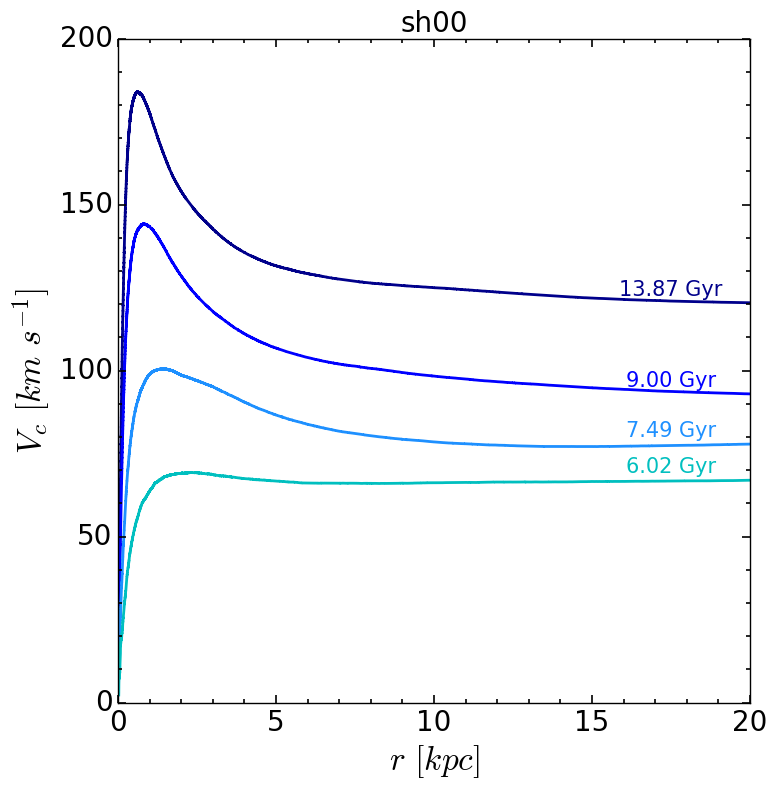

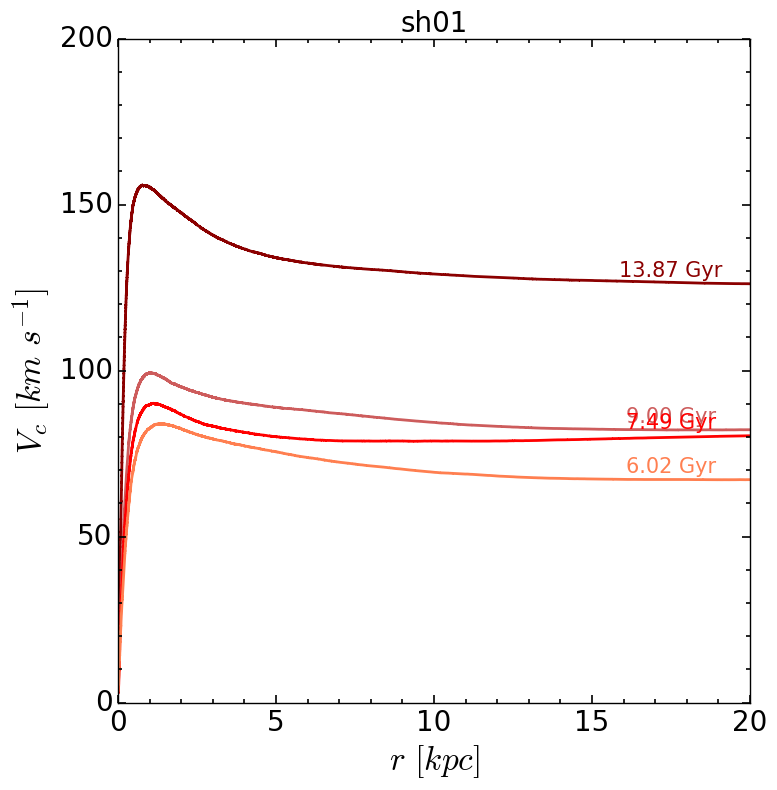

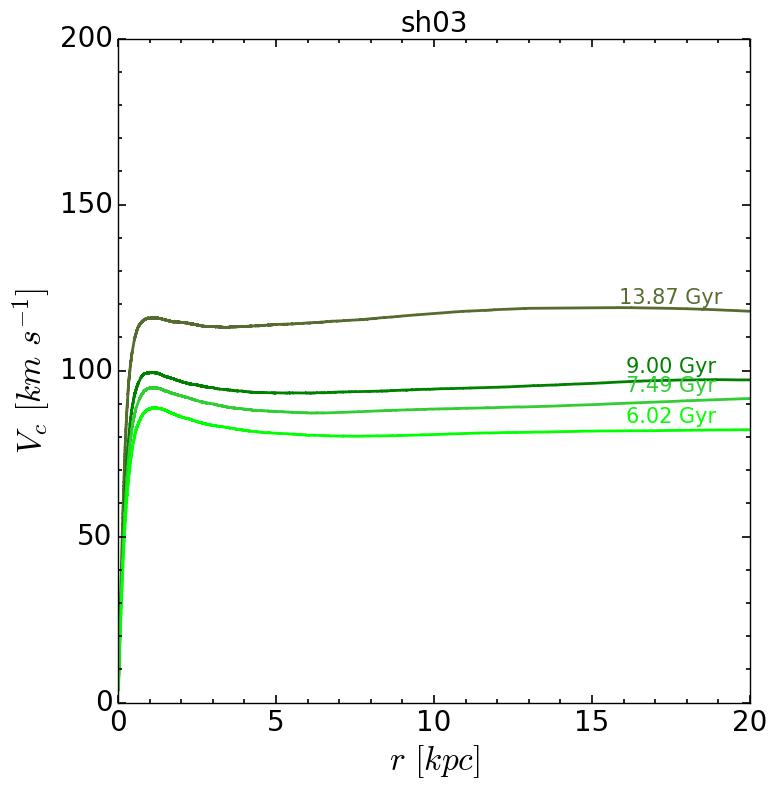

In [57]:
# Graficamos la veloc circular para distintos tiempos
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np

h=0.732
G = 4.299e-6
a0=1
omega_lambda=0.716
omega_matter=0.1277/(h**2.)

vect=np.array([['darkblue','blue', 'dodgerblue', 'c'],
              ['darkred','indianred' ,'red', 'coral'],
              ['darkolivegreen', 'green', 'limegreen', 'lime']])
vect2=(0,-20,-40,-60)

k=0
snapshot=(497,315,260,207)

for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    a = snap['subhalo_000/Time'].value
    z = (a0/a)-1
    t = conv(z, h, omega_lambda, omega_matter)
    for i in range(0,3):
        
        pstr = snap['subhalo_0'+ str('%s'%vector[i]) +'/Str/Coordinates'].value
        cm   = snap['subhalo_0'+ str('%s'%vector[i]) +'/Center'].value
        vel  = snap['subhalo_0'+ str('%s'%vector[i]) +'/Str/Velocities'].value
        masa_str = snap['subhalo_0'+ str('%s'%vector[i]) +'/Str/Masses'].value
        r200 = snap['subhalo_0'+ str('%s'%vector[i]) +'/R200'].value
        
        pgas = snap['subhalo_0'+ str('%s'%vector[i]) +'/Gas/Coordinates'].value
        masa_gas = snap['subhalo_0'+ str('%s'%vector[i]) +'/Gas/Masses'].value
        
        pdrk = snap['subhalo_0'+ str('%s'%vector[i]) +'/Drk/Coordinates'].value
        masa_drk = snap['subhalo_0'+ str('%s'%vector[i]) +'/Drk/Masses'].value
        
#----------coordenadas respecto al centro de la galaxia-----------------
        xstr = (pstr[:,0]-cm[0])/h
        ystr = (pstr[:,1]-cm[1])/h
        zstr = (pstr[:,2]-cm[2])/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])/h
        ygas = (pgas[:,1]-cm[1])/h
        zgas = (pgas[:,2]-cm[2])/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])/h
        ydrk = (pdrk[:,1]-cm[1])/h
        zdrk = (pdrk[:,2]-cm[2])/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
        
#----------------------masas----------------------------
        masa_str = masa_str/h
        masa_gas = masa_gas/h
        masa_drk = masa_drk/h
        
        rgal=0.15*r200
        
        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
        
        Mc_str = cumsum((masa_str[limit])[r_indice])
        
#------------------ calculamos r90, r50------------------------------------------
        M_gal = Mc_str[-1]
    
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
#--------------------------------------------------------------       
        rtot= concatenate([r,rgas,rdrk])
        mtot= concatenate([masa_str, masa_gas, masa_drk])
        
        limit_tot = np.where(rtot<20)
        rtot_sort = np.sort(rtot[limit_tot])
        rtot_indice = np.argsort(rtot[limit_tot])
        
        Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])
#--------------------------------------------------------------
        
        Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)
        
        fig=plt.figure(i,figsize=(8,8))
        fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
        ax=fig.add_subplot(111)
        ax.plot(rtot_sort,Vtot,'k', lw=2, color='%s'%vect[i,k])
        ax.set_title('sh'+ str('%s'%vector[i]), fontsize= 20)
        plt.xlabel(u'$r$ $[kpc]$', fontsize=24)
        plt.ylabel(u'$V_c$ $[km$ $s^{-1}]$', fontsize=24)
        plt.ylim(0,200)
        plt.xlim(0,20)
        #ax.set_xlim(0,rgal)
        ax.minorticks_on()
        ax.tick_params( labelsize=20)
        ax.tick_params('both', length=3, width=1.2,which='minor')
        ax.tick_params('both', length=6, width=1.2,which='major')
        plt.text(17.5, Vtot[-100]+1, '%.2f'%t + ' Gyr', va='bottom', ha='center',
                color='%s'%vect[i,k], fontsize=15)
        #plt.annotate(('%.2f'%t + ' Gyr'), xy=(5,30), xytext=(-10,vect2[k]),
        #             textcoords='figure points', fontsize=22, color = '%s'%vect[pp,k])
        fig.savefig('/home/ornela/python/Graficos3/sh0'+str('%s'%vector[i])+'-Vcs.png', dpi = 100)
    k+=1
    
plt.show()


r200 = 167.211748634


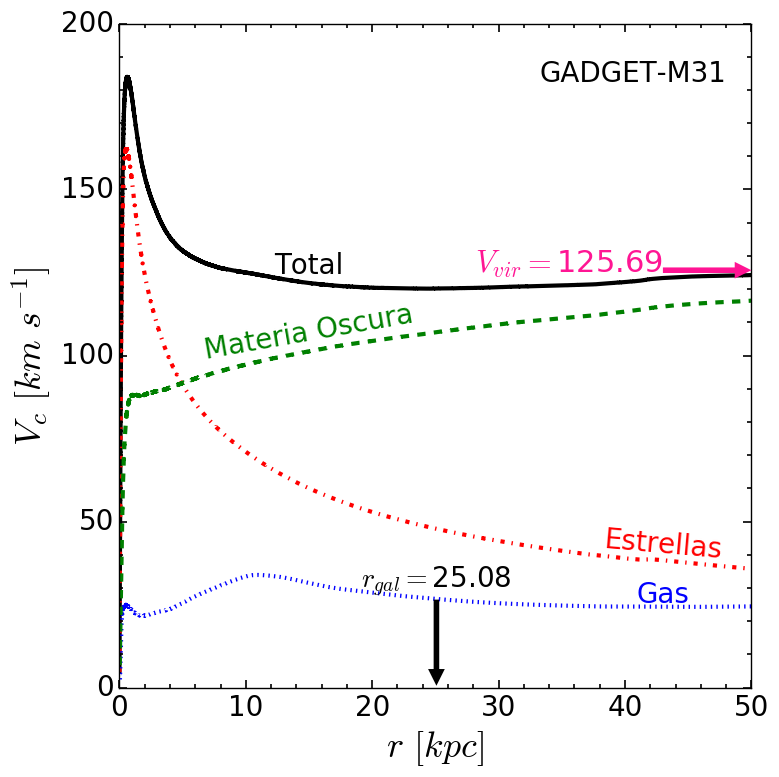

r200 = 153.542349727


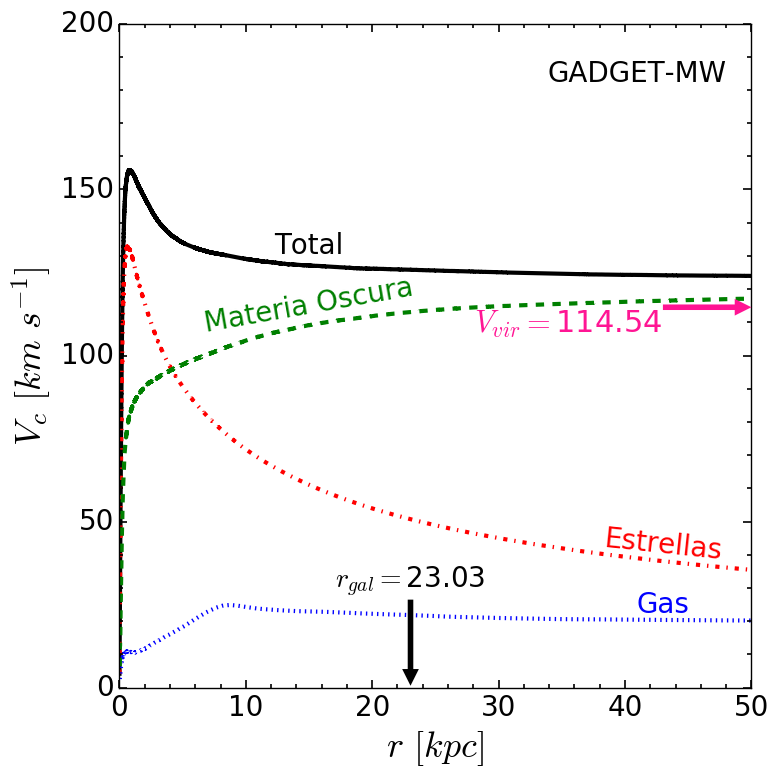

r200 = 123.112021858


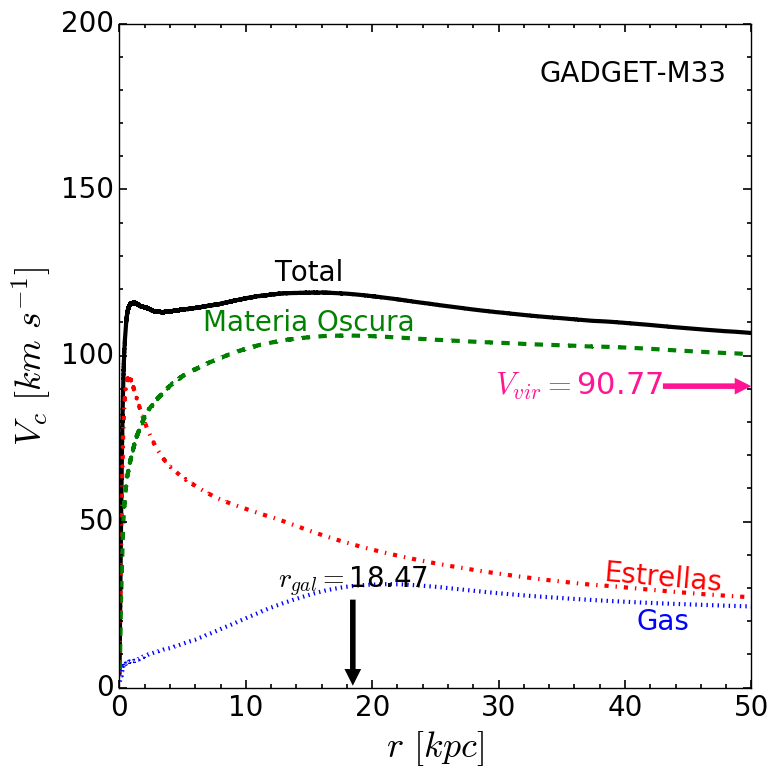

In [2]:
#Graficamos la veloc circular pero con la flecha de V200 y solo para los 3 halos mas grandes
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np

vector = ('00','01','03')
vector2 = ('b', 'r', 'g')
vector3 = ('darkblue', 'darkred', 'darkgreen')
vector4 = ('M31', 'MW', 'M33')
h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

snapshot=range(497,496,-1)

for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    for i in range(0,3):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value
        aexp = snap['subhalo_0'+ str('%s' %vector[i])+ '/Time'].value
        
        pstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        masa_str = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value
        
        pgas = snap['subhalo_0'+ str('%s' %vector[i])+ '/Gas/Coordinates'].value
        masa_gas = snap['subhalo_0'+ str('%s' %vector[i])+ '/Gas/Masses'].value
        
        pdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
        masa_drk = snap['subhalo_0'+ str('%s' %vector[i])+ '/Drk/Masses'].value
        
        z = a0/aexp - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp/h
        ystr = (pstr[:,1]-cm[1])*aexp/h
        zstr = (pstr[:,2]-cm[2])*aexp/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])*aexp/h
        ygas = (pgas[:,1]-cm[1])*aexp/h
        zgas = (pgas[:,2]-cm[2])*aexp/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])*aexp/h
        ydrk = (pdrk[:,1]-cm[1])*aexp/h
        zdrk = (pdrk[:,2]-cm[2])*aexp/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
         
        v_x = vel[:,0] *np.sqrt(aexp) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp) + Ht *zstr/1000.
#----------------------masas----------------------------
        masa_str = masa_str/h
        masa_gas = masa_gas/h
        masa_drk = masa_drk/h
        
        r200 = r200*aexp/h
        
        print 'r200 =', r200
        rgal=0.15*r200
        
        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
        
        limit_str = np.where(r<r200)
        rstr_sort = np.sort(r[limit_str])
        rstr_indice = np.argsort(r[limit_str])
        
        limit_gas = np.where(rgas<r200)
        rgas_sort = np.sort(rgas[limit_gas])
        rgas_indice = np.argsort(rgas[limit_gas])
        
        limit_drk = np.where(rdrk<r200)
        rdrk_sort = np.sort(rdrk[limit_drk])
        rdrk_indice = np.argsort(rdrk[limit_drk])
        
        
        Mgal_str = cumsum((masa_str[limit])[r_indice])
        
        Mc_str = cumsum((masa_str[limit_str])[rstr_indice])
        
        Mc_gas = cumsum((masa_gas[limit_gas])[rgas_indice])
        
        Mc_drk = cumsum((masa_drk[limit_drk])[rdrk_indice])
        
#------------------ calculamos r90, r50------------------------------------------
        M_gal = Mgal_str[-1]
    
        razon = Mgal_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
#--------------------------------------------------------------       
        rtot= concatenate([r,rgas,rdrk])
        mtot= concatenate([masa_str, masa_gas, masa_drk])
        
        limit_tot = np.where(rtot<r200)
        rtot_sort = np.sort(rtot[limit_tot])
        rtot_indice = np.argsort(rtot[limit_tot])
        
        Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])
        
        #print 'Mvir=', Mc_tot[-1], 'r50=', r50[-1]
#--------------------------------------------------------------
        
        Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)
        Vstr = np.sqrt((G*Mc_str*1e10)/rstr_sort)
        Vgas = np.sqrt((G*Mc_gas*1e10)/rgas_sort)
        Vdrk = np.sqrt((G*Mc_drk*1e10)/rdrk_sort)
        
        
#--------nuevo-----------------------------------------------------
        #limit_vir = np.where(r<r200)
        #r_vir_sort = np.sort(r[limit_vir])
        #r_vir_indice = np.argsort(r[limit_vir])
        
        #M_vir = cumsum((mtot[limit_vir])[r_vir_indice])
        
        #Vvir = np.sqrt((G*M_vir*1e10)/r_vir_sort)
        
        Vvir = Vtot[-1]

#----------------------------------------------------------------------------------
        fig=plt.figure(i,figsize=(8,8))
        fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
        ax=fig.add_subplot(111)
        total,= ax.plot(rtot_sort,Vtot,'-', lw=3, color='k', label= 'Total')
        stars,= ax.plot(rstr_sort,Vstr,'-.',lw=3, color='r', label ='Stars')
        gas,= ax.plot(rgas_sort,Vgas,':', color ='b',lw=3, label='Gas')
        drk,= ax.plot(rdrk_sort,Vdrk,'--',color='g', lw=3, label='Dark Matter')
        #ax.set_title('Gadget - '+ '%s'%vector4[i]+' ($z = 0$)', fontsize= 20)
        plt.text(48, 185, 'GADGET-'+'%s'%vector4[i], fontsize=20, color='black', ha='right', va='center')
        #plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
        plt.xlabel(u'$r$ $[kpc]$', fontsize=26)
        plt.ylabel(u'$V_c$ $[km$ $s^{-1}]$', fontsize=26)
        plt.ylim(0,200)
        plt.xlim(0,50)
        ax.minorticks_on()
        ax.tick_params( labelsize=20)
        ax.tick_params('both', length=3, width=1.2,which='minor')
        ax.tick_params('both', length=6, width=1.2,which='major')
        
        if i == 0:
            '''plt.annotate('', xy=(r50[-1],0), xytext=(r50[-1], 27), textcoords='data',
                         fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01))
            plt.text(1.5, 32, '$r_{50} =$'+ str('%.2f'%r50[-1]), fontsize=20, color='black', 
                     ha='left', va='center')
            #plt.annotate('$r_{90} =$'+ '%.2f'%r90[-1], xy=(r90[-1],0), xytext=(0, +90), textcoords='offset points', 
            #             fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="center")'''
            plt.annotate('', xy=(rgal,0), xytext=(rgal, 27), textcoords='data', 
                         fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01),ha="center")
            plt.text(rgal, 32, '$r_{gal} =$'+ str('%.2f'%rgal), fontsize=20, color='black', 
                     ha='center', va='center')
            plt.annotate('', xy=(50,Vvir), xytext=(43, Vvir), textcoords='data' ,ha="right", va='center',
                         arrowprops=dict(facecolor='deeppink',ec="none"))
            plt.text(43, Vvir+2, u'$V_{vir} =$'+ str('%.2f'%Vvir), fontsize=22, color='deeppink', 
                     ha='right', va='center')
            plt.text(43, 28, 'Gas', fontsize=20, color='b', ha='center', va='center')
            plt.text(43, 43, 'Estrellas', fontsize=20, color='r', ha='center', va='center',rotation= -5)
            plt.text(15, 107, 'Materia Oscura', fontsize=20, color='g', ha='center', va='center', rotation= 10)
            plt.text(15, 127, 'Total', fontsize=20, color='black', ha='center', va='center')
        elif i ==1:
            '''plt.annotate('', xy=(r50[-1],0), xytext=(r50[-1], 27), textcoords='data',
                         fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01))
            plt.text(1.5, 32, '$r_{50} =$'+ str('%.2f'%r50[-1]), fontsize=20, color='black', 
                     ha='left', va='center')
            #plt.annotate('$r_{90} =$'+ '%.2f'%r90[-1], xy=(r90[-1],0), xytext=(0, +90), textcoords='offset points', 
            #             fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="center")'''
            plt.annotate('', xy=(rgal,0), xytext=(rgal, 27), textcoords='data', 
                         fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01),ha="center")
            plt.text(rgal, 32, '$r_{gal} =$'+ str('%.2f'%rgal), fontsize=20, color='black', 
                     ha='center', va='center')
            plt.annotate('', xy=(50,Vvir), xytext=(43, Vvir), textcoords='data', ha="right", va='center',
                         arrowprops=dict(facecolor='deeppink', ec="none"))
            plt.text(43, Vvir-5, u'$V_{vir} =$'+ str('%.2f'%Vvir), fontsize=22, color='deeppink', 
                     ha='right', va='center')
            plt.text(43, 25, 'Gas', fontsize=20, color='b', ha='center', va='center')
            plt.text(43, 43, 'Estrellas', fontsize=20, color='r', ha='center', va='center', rotation= -6)
            plt.text(15, 115, 'Materia Oscura', fontsize=20, color='g', ha='center', va='center',rotation= 10)
            plt.text(15, 133, 'Total', fontsize=20, color='black', ha='center', va='center')
        else:
            '''plt.annotate('', xy=(r50[-1],0), xytext=(r50[-1], 27), textcoords='data',
                         fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01))
            plt.text(1.5, 32, '$r_{50} =$'+ str('%.2f'%r50[-1]), fontsize=20, color='black', 
                     ha='left', va='center')
            #plt.annotate('$r_{90} =$'+ '%.2f'%r90[-1], xy=(r90[-1],0), xytext=(0, +80), textcoords='offset points', 
            #             fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.1),ha="center")'''
            plt.annotate('', xy=(rgal,0), xytext=(rgal, 27), textcoords='data', 
                         fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01),ha="center")
            plt.text(rgal, 32, '$r_{gal} =$'+ str('%.2f'%rgal), fontsize=20, color='black', 
                     ha='center', va='center')
            plt.annotate('', xy=(50,Vvir), xytext=(43, Vvir), textcoords='data', ha="right", va='center',
                         arrowprops=dict(facecolor='deeppink', ec="none"))
            plt.text(43, Vvir, u'$V_{vir} =$'+ str('%.2f'%Vvir), fontsize=22, color='deeppink', 
                     ha='right', va='center')
            plt.text(43, 20, 'Gas', fontsize=20, color='b', ha='center', va='center')
            plt.text(43, 33, 'Estrellas', fontsize=20, color='r', ha='center', va='center',rotation= -5)
            plt.text(15, 110, 'Materia Oscura', fontsize=20, color='g', ha='center', va='center')
            plt.text(15, 125, 'Total', fontsize=20, color='black', ha='center', va='center')


        #fig.savefig('/home/ornela/Escritorio/seminario2/imagenes/Gd_'+str('%s'%vector4[i])+'-Vc.png', dpi = 100)
        #fig.savefig('/home/ornela/Escritorio/mi_tesis/Figures/GD_'+str('%s'%vector4[i])+'-Vc.png', dpi = 100)
        #fig.savefig('/home/ornela/Escritorio/presentacion_final/GD_'+str('%s'%vector4[i])+'-Vc.png', dpi = 100)
        plt.show()


In [4]:
vect=np.array([['darkblue','blue', 'royalblue', 'dodgerblue'],
                  ['darkred', 'red', 'orangered', 'salmon'],
                  ['darkgreen', 'green', 'mediumseagreen', 'limegreen']])

In [3]:
print masa_str*1e10, masa_gas*1e10, masa_drk*1e10

[ 30229.8828125  30229.8828125  30229.8828125 ...,  30229.8828125
  30229.8828125  30229.8828125] [ 60459.765625  60459.765625  60459.765625 ...,  60459.765625  60459.765625
  60459.765625] [ 286677.625  286677.625  286677.625 ...,  286677.625  286677.625
  286677.625]
